# AI ENTERPRISE WORKFLOW CERTIFICATION

### Capstone Project - Part 1. Data Investigation

---

## Introduction

Recently at AAVAIL there has been discussion among management about different approaches to revenue generation. AAVAIL launched using a tiered, subscription-based service which showed promise, but conversations with users, especially those outside of US markets, prompted an experiment using an à la carte approach. This experiment was carried out mostly outside of the US and there are now a couple of years of data with a few thousand active users. The data are transaction-level purchases across 38 different countries and are invoiced in batches. Management has nearly decided to make the switch to the new model, but they find it difficult to predict monthly revenue. They have asked you to create a service that, at any point in time, will predict the revenue for the following month. They have also asked that the service be given the ability to project revenue for a specific country. To keep the development time reasonable you have been advised to limit your model to the ten countries with the most revenue.

You have spoken at length with the managers who will be the end users of this model and they are confident that this product will have a meaningful business impact. Currently, these managers are using their own methods to predict revenue, but they have come to feel that they are spending too much time on this and their lack of expertise in data science means their predictions are not as accurate as they would like. The management team expects to spend less time creating their own projection models, and they expect the new results to be more accurate. They have assured you that well-projected numbers will help stabilize staffing and budget projections which will have a beneficial ripple effect throughout the company.


In [1]:
%matplotlib inline

## Deliverables

### 1. Assimilate the business scenario and articulate a testable hypthothesis.

The main objective are as follows:
* Create a tool that predicts revenue for the upcoming month.
* Said tool needs the ability to predict revenue for a given country.
* Limit said model to the 10 countries with the greatest revenue.


The tool's end user will be management. Currently the current methods for predicting revenue are time consuming and inaccurate. Such as a tool will assist with budgeting and so on.

**Testable Hypthesis:** This tool will allow for more accurate prediction that is less prone to human error.

### 2. State the ideal data to address the business opportunity and clarify thew rationale for requiring such data.

Ultimately our goal is to estimate revenue for the upcoming month. Data regarding past revenue, or data that can be used to derive historical revenue would be ideal.

### 3. Create a python script to extract relevant data from multiple data sources, automating the process of data ingestion.

#### A possible script for automising the Data Ingestion Process is as follows:

In [2]:
%%writefile data_ingestion.py

import pandas as pd
import numpy as np
import os
import re
import time


PROJECT_ROOT_DIR = '.'
DATA_DIR = os.path.join('.', 'data','cs-train')
TS_DIR = os.path.join('data', 'ts-data')

def load_avvail_data(data_dir):
    """
    Load all the json files into a single dataframe
    """
    
    files = [os.path.join(data_dir,file) for file in os.listdir(data_dir) if re.search('\.json',file)]
    
    df_list = [pd.read_json(file) for file in files]
    df_list = [df.rename(columns = {'StreamID' : 'stream_id',
                                    'TimesViewed' : 'times_viewed',
                                    'total_price': 'price'}) for df in df_list]
    
    df = pd.concat(df_list, sort = True)
    
    
    df['dates'] = pd.to_datetime(df[['year', 'month', 'day']])
    df['year_month'] = [str(date)[0:7] for date in df.dates]
   # df.to_csv(os.path.join('data','all-invoices.csv'),index = False)
                                     

    return df



def timeseries_aggregate(dataframe, country = None):
    """
    Aggregate data into a daily timeseries. Country can be selected to generate data
    for only a single country
    """

    
    if country != None:
        dataframe = dataframe[dataframe.country == country]


    #Create a date range to ensure no dates are missing from the data.
    first_date = dataframe['dates'].min()
    last_date = dataframe['dates'].max()
    date_range  = pd.date_range(first_date, last_date, freq = 'D')
    
    
    daily_revenue = [dataframe[dataframe['dates'] == days]['price'].sum() for days in date_range]
    daily_views = [dataframe[dataframe['dates'] == days]['times_viewed'].sum() for days in date_range]
    daily_purchases = [dataframe[dataframe['dates'] == days]['price'].size for days in date_range]
    
    
    dataframe_dict= {
        'daily_revenue' : daily_revenue,
        'daily_views' : daily_views,
        'daily_purchases': daily_purchases,
        'dates': date_range
    }
    
    
    timeseries_df = pd.DataFrame(dataframe_dict)
    
    return timeseries_df


def load_ts(ts_dir = TS_DIR, replace = False, verbose = True):
    """
    Function to read in timeseries formatted data. Option to replace/recreate files if the user desires. Set 
    replace = True to accomplish this.
    """
    
    
    if not os.path.exists(TS_DIR):
        os.mkdir(os.path.join(TS_DIR))
                 
    ## Load in files.
    ts_files = [os.path.join(TS_DIR,file) for file in os.listdir(TS_DIR) if re.search('\.csv',file)]             
    if (len(ts_files) > 0) & (replace == False):
        if verbose:
            print('Ingesting timeseries data from files.')
        ts = {re.sub('.csv','',os.path.split(file)[1][3:]) : pd.read_csv(file) for file in ts_files}
        return(ts)

    df = load_avvail_data(os.path.join('data','cs-train'))
    
    ## Determine top 10 countries wrt revenue.
    top10_countries = df.groupby('country', as_index = False).\
    agg({'price':'sum'}).sort_values('price', ascending = False).country[:10]       
            
    # Convert the data into timeseries.
    ts = {}

    for country in top10_countries:
        ts[country] = timeseries_aggregate(df, country = country)
        ts[country].to_csv(os.path.join(TS_DIR, f'ts_{country}.csv'), index = False)
    
    ts['all'] = timeseries_aggregate(df, country = None)
    ts['all'].to_csv(os.path.join(TS_DIR, f'ts_all.csv'), index = False)
    
    return(ts)
        



def engineer_features(dataframe, training = True):
    """
    Engineer features as to prepare them for modelling. Our Goal is to model the
    next 30 days of revenue, so for any given day that will be the target.
    """
    
    if training:
        dataframe = dataframe.head(dataframe.shape[0] - 30)

    
    eng_df = pd.DataFrame({})
    
    #Engineer the target.
    eng_df['target'] = [dataframe.daily_revenue[i:i+30].sum() for i in range(dataframe.shape[0])]

    #Engineer the features.
    past_intervals = [7,14,30,60, 365]
    for interval in past_intervals:
         eng_df[f'revenue_{interval}d'] = dataframe.rolling(interval, min_periods = 1)['daily_revenue'].sum()
        
    #Add some non-revenue features
    eng_df[f'views_{30}d'] = dataframe.rolling(30, min_periods = 1)['daily_views'].sum()
    eng_df[f'purchases_{30}d'] = dataframe.rolling(30, min_periods = 1)['daily_purchases'].sum()
    
    
    dates = dataframe.dates
    eng_df['dates'] = dates
    
    return eng_df

if __name__ == "__main__":
    
    run_start = time.time()
  
    ## ingest data
    ts = load_ts(TS_DIR, replace = True)
    
    ## 
    m, s = divmod(time.time()-run_start,60)
    h, m = divmod(m, 60)
    print("...run time:", "%d:%02d:%02d"%(h, m, s))
    
    print("done")

Overwriting data_ingestion.py


In [3]:
%run data_ingestion.py

...run time: 0:00:26
done


### 4. Investigate the relationship between the relevant data, the target and the business metric.

#### Automate Data Visualisation

In [4]:
%%writefile data_visualisation.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import time
import re

IMAGE_DIR = os.path.join('images')

#Import functions from data_ingestion script.
from data_ingestion import load_avvail_data



def save_fig(figure_id):
    """
    Save Images as pdf.
    """
    
    #Check Directory
    if not os.path.exists(IMAGE_DIR):
        os.makedirs(IMAGE_DIR)
        
    image_path = os.path.join('images', figure_id + '.png')
    plt.savefig(image_path, format = 'png')
    



def create_plots(df):
    """
    Generate plots
    """
    sns.set_style('darkgrid')
    
    
    #Total revenues over time.
    fig, ax = plt.subplots(figsize=(20, 10)) 
    
    df1 = df.groupby(['year_month'], as_index = False).agg({'price':'sum'})
    df1.plot(x = 'year_month', y = 'price', ax = ax)
    plt.xlabel('Dates')
    plt.ylabel('Total Revenue')
    plt.title('Total Revenue over Time')
    save_fig('Revenue over Time')
    
    
    #Total revenues for top 10 countries
    fig, ax = plt.subplots(figsize=(20, 10)) 
    top_countries = [country for country in df.groupby('country', as_index = False).agg({'price':'sum'}).\
                sort_values('price', ascending = False).head(10).country]
    df2 = df[np.isin(df.country,top_countries)]
    df2 = df2.groupby(['year_month', 'country'], as_index = False).agg({'price' : 'sum'})
    sns.lineplot(x = df2.year_month, y = df2.price, hue = df2.country)
    plt.xlabel('Dates')
    plt.ylabel('Revenue')
    plt.title('Total Revenue over Time (Top 10 Countries)')
    save_fig('Revenue for the Top 10 Countries')
    
    
    #Total revenues for top 10 countries (minus United Kingdom)
    fig, ax = plt.subplots(figsize=(20, 10)) 
    top_countries = [country for country in df.groupby('country', as_index = False).agg({'price':'sum'}).\
                sort_values('price', ascending = False).head(10).country]
    df2 = df[np.isin(df.country,top_countries)]
    df2 = df2.groupby(['year_month', 'country'], as_index = False).agg({'price' : 'sum'})
    df2 = df2[df2.country != 'United Kingdom']
    sns.lineplot(x = df2.year_month, y = df2.price, hue = df2.country)
    plt.xlabel('Dates')
    plt.ylabel('Revenue')
    plt.title('Top Country Revenue (Minus United Kingdom)')
    save_fig('Top Country Revenue (Minus United Kingdom)')
    
    
    
    #Total Revenues per year.
    fig, ax = plt.subplots(figsize=(20, 10)) 
    df3 = df.groupby('year', as_index = False).agg({'price':'sum'})
    sns.barplot(x = df3.year, y = df3.price)
    plt.xlabel('Years')
    plt.ylabel('Revenue')
    plt.title('Total Revenue by Year')
    save_fig('Revenue by Year')
    
    
    
if __name__ == "__main__":
    
    run_start = time.time()
    
    df = load_avvail_data(os.path.join('data','cs-train'))
    create_plots(df)
    
    print("METADATA")
    m, s = divmod(time.time()-run_start,60)
    h, m = divmod(m, 60)
    print("...run time:", "%d:%02d:%02d"%(h, m, s))
    
    print("done")    

Overwriting data_visualisation.py


In [5]:
%run data_visualisation.py

METADATA
...run time: 0:00:10
done


### 5. Articulate your findings using a deliverable with visualizations

We look at what we have found in the data.

In [6]:
from data_ingestion import load_avvail_data, DATA_DIR
from IPython.display import Image
import os


df = load_avvail_data(DATA_DIR)
df.head()

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,dates,year_month
0,United Kingdom,13085.0,28,489434,11,6.95,85048,12,2017,2017-11-28,2017-11
1,United Kingdom,NaN,28,489597,11,8.65,22130,1,2017,2017-11-28,2017-11
2,United Kingdom,NaN,28,489597,11,1.70,22132,6,2017,2017-11-28,2017-11
3,United Kingdom,NaN,28,489597,11,1.70,22133,4,2017,2017-11-28,2017-11
4,United Kingdom,NaN,28,489597,11,0.87,22134,1,2017,2017-11-28,2017-11


The top countries are as follows...

In [7]:
df.groupby('country', as_index = False).agg({'price':'sum'}).sort_values('price', ascending = False).head(10)

,country,price
40,United Kingdom,3.521514e+06
11,EIRE,1.070692e+05
15,Germany,4.927182e+04
14,France,4.056514e+04
28,Norway,3.849475e+04
34,Spain,1.604099e+04
17,Hong Kong,1.445257e+04
30,Portugal,1.352867e+04
33,Singapore,1.317592e+04
26,Netherlands,1.232280e+04


UK dominates the sales charts

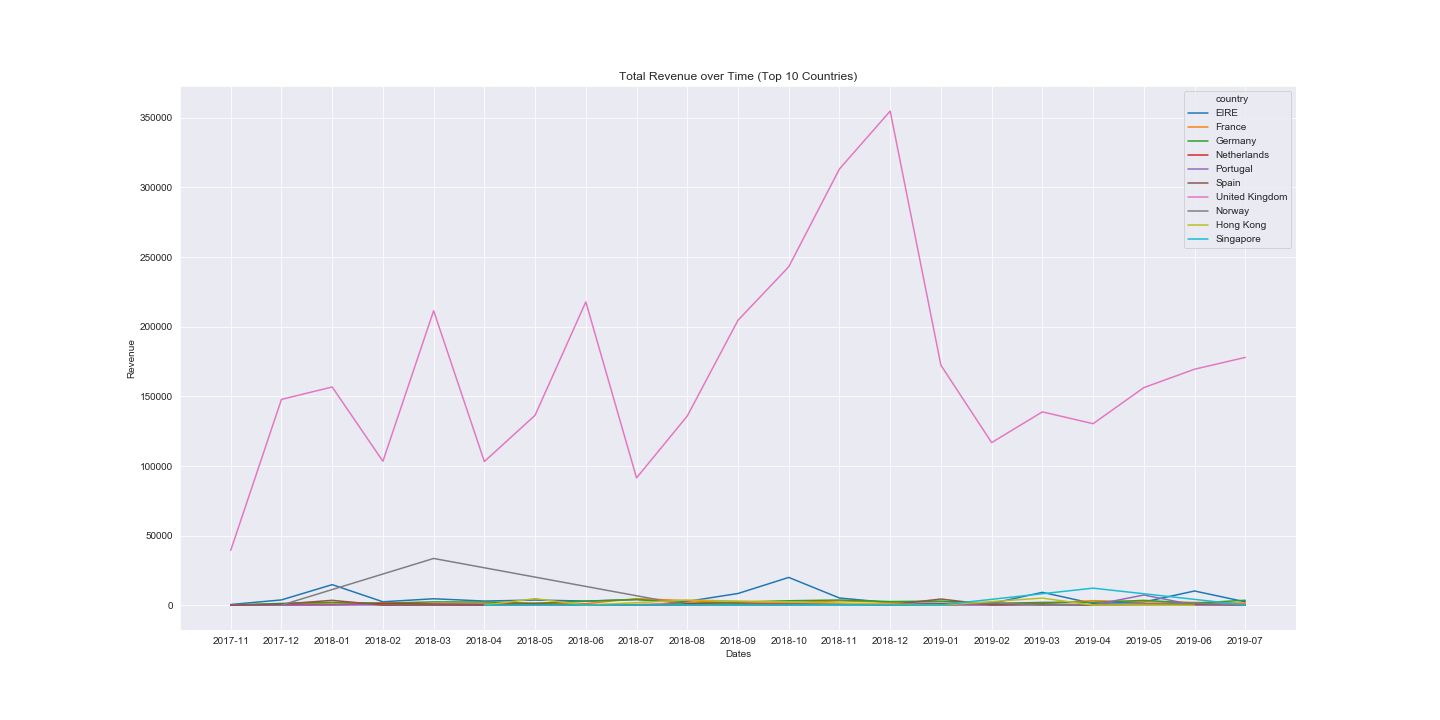

In [8]:
Image("./images/Revenue for the Top 10 Countries.png")

UK dominates revenue to the point where it seems that the UK accounts for most of AVVAIL's total revenue

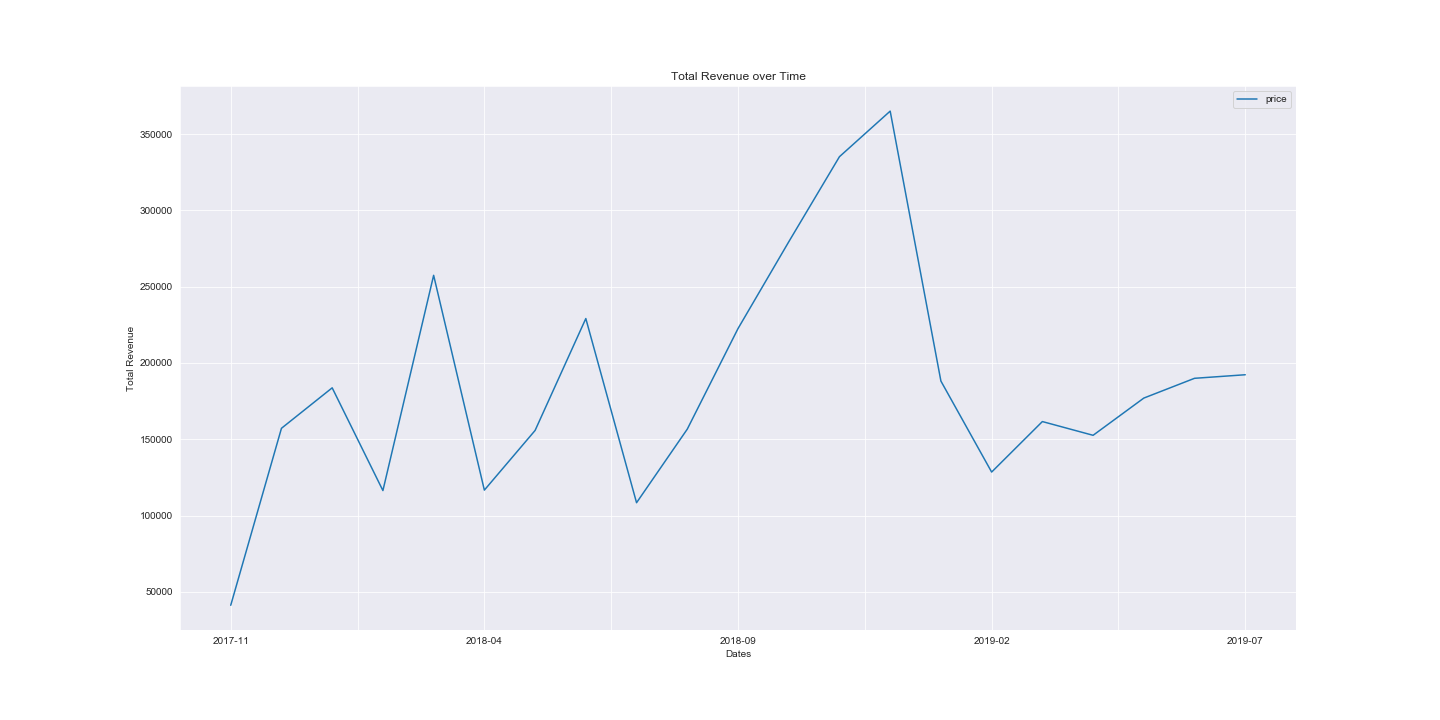

In [9]:
Image("./images/Revenue over Time.png")

It is currently not possible to measure seasonality since the only full year we have on record is 2018.

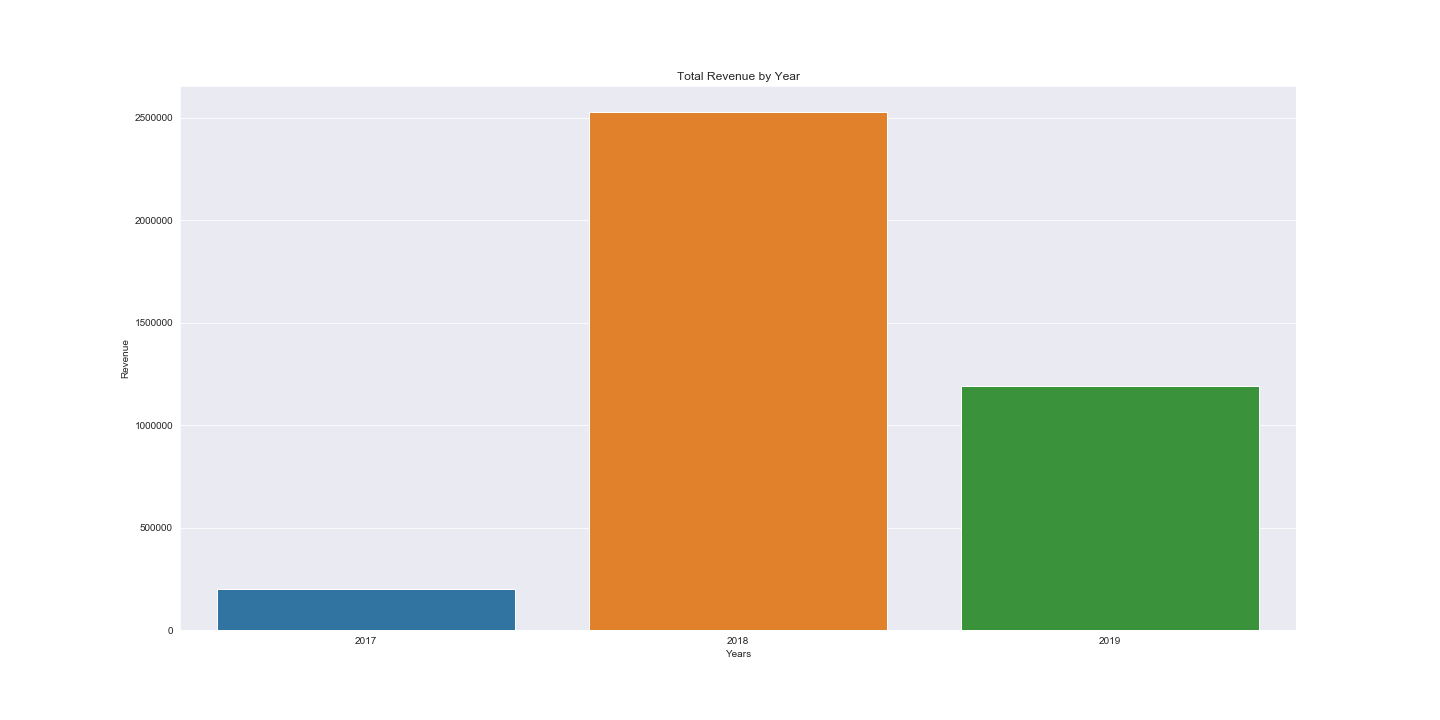

In [10]:
Image("./images/Revenue by Year.png")

* There is seems top be a sharp decline in revenue 2019 though the year is incomplete according to the data.
* On a similiar note there seems to be a huge increase in revenue from 2017 - 2018. However revenue the data indicated revenue was only being generated from late 2017.